## Dynamic Kernel Size

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('Using GPU(0):', physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
else:
    print('Using CPU')

import numpy as np
from numpy.random import shuffle
import time
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline

# Notebook auto reload code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2
print(tf.__version__)

Using GPU(0): PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.4.0


In [2]:
import tensorflow as tf
import os
import shutil

data_dir = "tiny-imagenet-10"  # Folder name after extraction

# Get the list of all class directories in the training set
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [3]:
import shutil

# Define preprocessing
IMG_SIZE = 224  # Resize all images to 224x224
BATCH_SIZE = 8

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Load the datasets
# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',  # Labels are integers
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


Found 5000 files belonging to 10 classes.


In [4]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Test Dataset (if test labels exist)
# If no labels, use label_mode=None
try:
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        label_mode=None,  # Set None if labels are not available
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=False
    ).map(lambda x: tf.image.resize(x, [IMG_SIZE, IMG_SIZE]) / 255.0, 
          num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
except Exception as e:
    test_ds = None
    print(f"No test dataset found: {e}")

# Check dataset shapes
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)
for images, labels in val_ds.take(1):
    print("Validation batch shape:", images.shape, labels.shape)

if test_ds:
    for images in test_ds.take(1):
        print("Test batch shape:", images.shape)

Found 500 files belonging to 10 classes.
No test dataset found: name 'test_dir' is not defined
Train batch shape: (8, 224, 224, 3) (8,)
Validation batch shape: (8, 224, 224, 3) (8,)


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

class DynamicDepthwiseConv2D(layers.Layer):    # Define the dynamic layers
    def __init__(self, kernel_sizes, **kwargs):
        super(DynamicDepthwiseConv2D, self).__init__()
        self.kernel_sizes = kernel_sizes
        self.depthwise_convs = [layers.DepthwiseConv2D(k, padding='same', **kwargs) for k in kernel_sizes]
        self.alpha = self.add_weight(shape=(len(kernel_sizes),),
                                     initializer='ones',
                                     trainable=True,
                                     name='alpha')

    def call(self, x):
        outputs = [conv(x) for conv in self.depthwise_convs]
        alphas = tf.nn.softmax(self.alpha)
        # Direct indexing approach:
        combined = tf.add_n([alphas[i] * outputs[i] for i in range(len(self.kernel_sizes))])
        return combined

def ConvMixer(dim, depth, kernel_sizes=[3,7,9], patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks with DynamicDepthwiseConv2D
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                # Replace the single DepthwiseConv2D with our dynamic layer
                DynamicDepthwiseConv2D(kernel_sizes=kernel_sizes),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    return Sequential(layers_list)

In [ ]:
from utils.DynamicConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = [2, 4, 6, 8, 10]
patch_size = 7
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_sizes=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 512)       75776     
_________________________________________________________________
activation_51 (Activation)   (None, 32, 32, 512)       0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 32, 32, 512)       2048      
_________________________________________________________________
sequential_52 (Sequential)   (None, 32, 32, 512)       381957    
_________________________________________________________________
sequential_54 (Sequential)   (None, 32, 32, 512)       381957    
_________________________________________________________________
sequential_56 (Sequential)   (None, 32, 32, 512)       381957    
_________________________________________________________________
sequential_58 (Sequential)   (None, 32, 32, 512)     

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [19]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")


In [20]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 187s 291ms/step - loss: 2.1712 - sparse_categorical_accuracy: 0.2635 - val_loss: 2.3746 - val_sparse_categorical_accuracy: 0.3420
Epoch 1 time: 186.55 seconds
Epoch 2/15
625/625 [==============================] - 181s 289ms/step - loss: 1.6668 - sparse_categorical_accuracy: 0.4117 - val_loss: 2.8521 - val_sparse_categorical_accuracy: 0.4020
Epoch 2 time: 180.92 seconds
Epoch 3/15
625/625 [==============================] - 181s 289ms/step - loss: 1.4658 - sparse_categorical_accuracy: 0.4957 - val_loss: 1.7416 - val_sparse_categorical_accuracy: 0.4660
Epoch 3 time: 180.86 seconds
Epoch 4/15
625/625 [==============================] - 181s 290ms/step - loss: 1.2937 - sparse_categorical_accuracy: 0.5612 - val_loss: 2.6645 - val_sparse_categorical_accuracy: 0.5140
Epoch 4 time: 181.02 seconds
Epoch 5/15
625/625 [==============================] - 181s 290ms/step - loss: 1.1648 - sparse_categorical_accuracy: 0.6043 - val_loss: 1.4802 - val_

In [21]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 4s 66ms/step - loss: 1.2669 - sparse_categorical_accuracy: 0.6900
Validation Loss: 1.2669
Validation Accuracy: 69.0000%


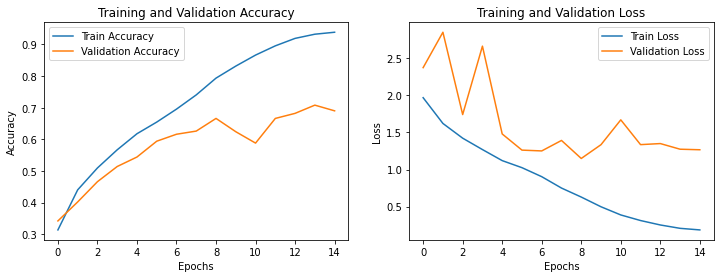

In [22]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

## Other Static Kernels

# Kernel = 2

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same"),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    # Build the model
    return Sequential(layers_list)

In [ ]:
from utils.ConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 2
patch_size = 7
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 512)       75776     
_________________________________________________________________
activation_68 (Activation)   (None, 32, 32, 512)       0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 32, 32, 512)       2048      
_________________________________________________________________
sequential_69 (Sequential)   (None, 32, 32, 512)       269312    
_________________________________________________________________
sequential_71 (Sequential)   (None, 32, 32, 512)       269312    
_________________________________________________________________
sequential_73 (Sequential)   (None, 32, 32, 512)       269312    
_________________________________________________________________
sequential_75 (Sequential)   (None, 32, 32, 512)     

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [26]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")


In [27]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 74s 115ms/step - loss: 2.0320 - sparse_categorical_accuracy: 0.3061 - val_loss: 1.8912 - val_sparse_categorical_accuracy: 0.3560
Epoch 1 time: 74.33 seconds
Epoch 2/15
625/625 [==============================] - 71s 114ms/step - loss: 1.6549 - sparse_categorical_accuracy: 0.4222 - val_loss: 2.3204 - val_sparse_categorical_accuracy: 0.4140
Epoch 2 time: 71.39 seconds
Epoch 3/15
625/625 [==============================] - 71s 114ms/step - loss: 1.5330 - sparse_categorical_accuracy: 0.4723 - val_loss: 1.6515 - val_sparse_categorical_accuracy: 0.4780
Epoch 3 time: 71.43 seconds
Epoch 4/15
625/625 [==============================] - 71s 114ms/step - loss: 1.4250 - sparse_categorical_accuracy: 0.5094 - val_loss: 2.5820 - val_sparse_categorical_accuracy: 0.5020
Epoch 4 time: 71.36 seconds
Epoch 5/15
625/625 [==============================] - 71s 114ms/step - loss: 1.3818 - sparse_categorical_accuracy: 0.5294 - val_loss: 1.8458 - val_sparse_ca

In [28]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 2s 33ms/step - loss: 2.0722 - sparse_categorical_accuracy: 0.5280
Validation Loss: 2.0722
Validation Accuracy: 52.8000%


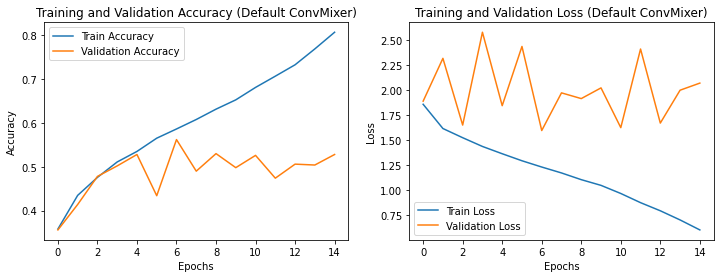

In [29]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Default ConvMixer)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Default ConvMixer)')

plt.show()

# Kernel = 6

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same"),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    # Build the model
    return Sequential(layers_list)

In [ ]:
from utils.ConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 6
patch_size = 7
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 512)       75776     
_________________________________________________________________
activation_85 (Activation)   (None, 32, 32, 512)       0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 32, 32, 512)       2048      
_________________________________________________________________
sequential_86 (Sequential)   (None, 32, 32, 512)       285696    
_________________________________________________________________
sequential_88 (Sequential)   (None, 32, 32, 512)       285696    
_________________________________________________________________
sequential_90 (Sequential)   (None, 32, 32, 512)       285696    
_________________________________________________________________
sequential_92 (Sequential)   (None, 32, 32, 512)    

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [33]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")


In [34]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 84s 131ms/step - loss: 2.1433 - sparse_categorical_accuracy: 0.2567 - val_loss: 2.6102 - val_sparse_categorical_accuracy: 0.3280
Epoch 1 time: 84.42 seconds
Epoch 2/15
625/625 [==============================] - 81s 130ms/step - loss: 1.6565 - sparse_categorical_accuracy: 0.4198 - val_loss: 6.3881 - val_sparse_categorical_accuracy: 0.2860
Epoch 2 time: 81.27 seconds
Epoch 3/15
625/625 [==============================] - 81s 130ms/step - loss: 1.4519 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.8949 - val_sparse_categorical_accuracy: 0.4920
Epoch 3 time: 81.23 seconds
Epoch 4/15
625/625 [==============================] - 81s 130ms/step - loss: 1.3000 - sparse_categorical_accuracy: 0.5616 - val_loss: 1.2128 - val_sparse_categorical_accuracy: 0.5780
Epoch 4 time: 81.16 seconds
Epoch 5/15
625/625 [==============================] - 81s 130ms/step - loss: 1.1621 - sparse_categorical_accuracy: 0.6060 - val_loss: 1.3464 - val_sparse_ca

In [35]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 2s 35ms/step - loss: 1.4693 - sparse_categorical_accuracy: 0.6500
Validation Loss: 1.4693
Validation Accuracy: 65.0000%


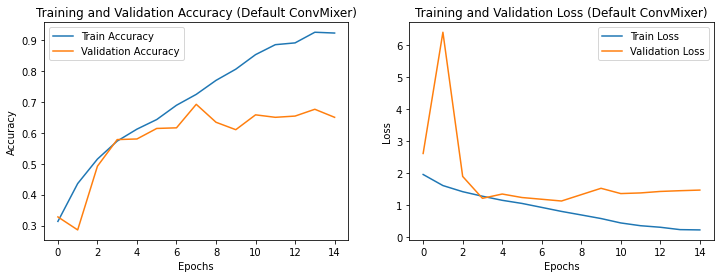

In [36]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Default ConvMixer)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Default ConvMixer)')

plt.show()

# Kernel = 10

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same"),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    # Build the model
    return Sequential(layers_list)

In [ ]:
from utils.ConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 10
patch_size = 7
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 32, 32, 512)       75776     
_________________________________________________________________
activation_102 (Activation)  (None, 32, 32, 512)       0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 32, 32, 512)       2048      
_________________________________________________________________
sequential_103 (Sequential)  (None, 32, 32, 512)       318464    
_________________________________________________________________
sequential_105 (Sequential)  (None, 32, 32, 512)       318464    
_________________________________________________________________
sequential_107 (Sequential)  (None, 32, 32, 512)       318464    
_________________________________________________________________
sequential_109 (Sequential)  (None, 32, 32, 512)    

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [40]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")


In [41]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 106s 165ms/step - loss: 2.2011 - sparse_categorical_accuracy: 0.2488 - val_loss: 3.0897 - val_sparse_categorical_accuracy: 0.3100
Epoch 1 time: 105.86 seconds
Epoch 2/15
625/625 [==============================] - 103s 164ms/step - loss: 1.7283 - sparse_categorical_accuracy: 0.3972 - val_loss: 2.0496 - val_sparse_categorical_accuracy: 0.4120
Epoch 2 time: 102.82 seconds
Epoch 3/15
625/625 [==============================] - 103s 164ms/step - loss: 1.5180 - sparse_categorical_accuracy: 0.4650 - val_loss: 2.4192 - val_sparse_categorical_accuracy: 0.3600
Epoch 3 time: 102.70 seconds
Epoch 4/15
625/625 [==============================] - 103s 164ms/step - loss: 1.3605 - sparse_categorical_accuracy: 0.5105 - val_loss: 1.4636 - val_sparse_categorical_accuracy: 0.5380
Epoch 4 time: 102.62 seconds
Epoch 5/15
625/625 [==============================] - 103s 164ms/step - loss: 1.2265 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.3736 - val_

In [42]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 3s 39ms/step - loss: 1.3000 - sparse_categorical_accuracy: 0.6880
Validation Loss: 1.3000
Validation Accuracy: 68.8000%


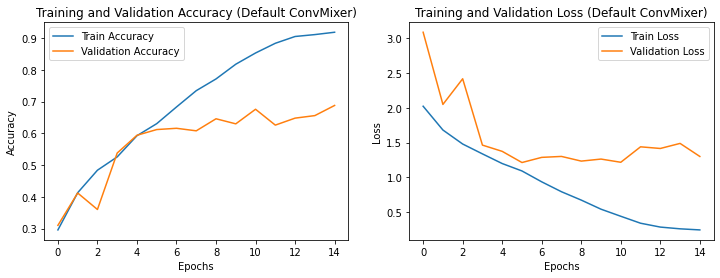

In [43]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Default ConvMixer)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Default ConvMixer)')

plt.show()

# Kernel = 14

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same"),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    # Build the model
    return Sequential(layers_list)

In [ ]:
from utils.ConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 14
patch_size = 7
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 32, 32, 512)       75776     
_________________________________________________________________
activation_119 (Activation)  (None, 32, 32, 512)       0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 32, 32, 512)       2048      
_________________________________________________________________
sequential_120 (Sequential)  (None, 32, 32, 512)       367616    
_________________________________________________________________
sequential_122 (Sequential)  (None, 32, 32, 512)       367616    
_________________________________________________________________
sequential_124 (Sequential)  (None, 32, 32, 512)       367616    
_________________________________________________________________
sequential_126 (Sequential)  (None, 32, 32, 512)    

In [46]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [47]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")


In [48]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 255s 403ms/step - loss: 2.2606 - sparse_categorical_accuracy: 0.2284 - val_loss: 2.3449 - val_sparse_categorical_accuracy: 0.2240
Epoch 1 time: 254.81 seconds
Epoch 2/15
625/625 [==============================] - 252s 403ms/step - loss: 1.7599 - sparse_categorical_accuracy: 0.3715 - val_loss: 1.8440 - val_sparse_categorical_accuracy: 0.3840
Epoch 2 time: 251.63 seconds
Epoch 3/15
625/625 [==============================] - 251s 402ms/step - loss: 1.5938 - sparse_categorical_accuracy: 0.4304 - val_loss: 1.9373 - val_sparse_categorical_accuracy: 0.4020
Epoch 3 time: 251.49 seconds
Epoch 4/15
625/625 [==============================] - 252s 403ms/step - loss: 1.4418 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.6827 - val_sparse_categorical_accuracy: 0.4720
Epoch 4 time: 251.62 seconds
Epoch 5/15
625/625 [==============================] - 252s 403ms/step - loss: 1.2934 - sparse_categorical_accuracy: 0.5550 - val_loss: 1.4790 - val_

In [49]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 3s 45ms/step - loss: 1.6931 - sparse_categorical_accuracy: 0.6480
Validation Loss: 1.6931
Validation Accuracy: 64.8000%


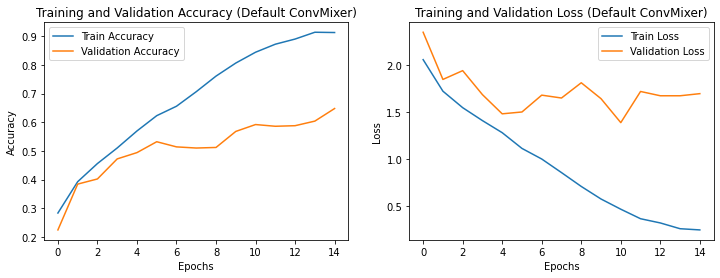

In [50]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Default ConvMixer)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Default ConvMixer)')

plt.show()